### Replication of Uber's "CoordConv" Paper results

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
onehots = np.pad(np.eye(3136,dtype=np.float32).reshape((3136, 56, 56, 1)), ((0,0), (4,4), (4,4), (0,0)), "constant")
images_tensor = tf.nn.conv2d(onehots, np.ones((9, 9, 1, 1)), [1]*4, "SAME")
labels = np.argwhere(onehots!=0)[:,1:3]

In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
with tf.Session(config=config) as sess:
    images = sess.run(images_tensor)

In [4]:
#inds = np.random.permutation(np.arange(images.shape[0]))
inds = np.arange(images.shape[0])
ct = int(images.shape[0]*.75)

#ct_train = np.arange(ct)
#ct_test = np.arange(ct,onehots.shape[0])

ct_train = []
ct_test = []
for i in range(onehots.shape[0]):
    if labels[i][0] < 60 and labels[i][0] > 30 and labels[i][1] < 60 and labels[i][1] > 30:
        ct_test.append(i)
    else:
        ct_train.append(i)

x_train = onehots[inds][ct_train]
y_train = labels[inds][ct_train]
x_test = onehots[inds][ct_test]
y_test = labels[inds][ct_test]

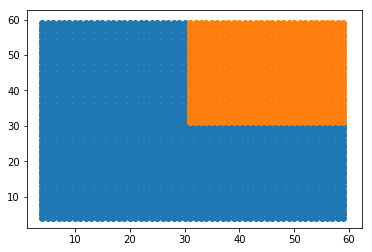

In [5]:
plt.scatter(y_train[:,0],y_train[:,1])
plt.scatter(y_test[:,0],y_test[:,1])
plt.show()

## Experiment 1: Supervised Coordinate Regression
(Given the image with painted pixel, predict the [x,y] coordinates)

In [6]:
tf.reset_default_graph()

y = tf.placeholder(tf.float32,shape=(None,2))
X = tf.placeholder(tf.float32,shape=(None, 64, 64, 1))

act = tf.nn.relu

net = tf.layers.conv2d(X,16,3,2,activation=act)
net = tf.layers.conv2d(net,16,3,2,activation=act)
net = tf.layers.conv2d(net,16,3,2,activation=act)
net = tf.layers.conv2d(net,16,3,1,activation=act)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, 64, activation=act)
net = tf.layers.dense(net,2,activation=None)

loss = tf.reduce_mean(tf.square(y-net))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
num_epochs = 250
bs = 32
num_its_per_epoch = int(x_train.shape[0]/bs)

losses = []
val_losses = []
test_every = 50

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for ep in tqdm(range(num_epochs)):
        for it in range(num_its_per_epoch):
            x_batch = x_train[it*bs: (it+1)*bs]
            y_batch = y_train[it*bs: (it+1)*bs]
            
            _, l = sess.run([train_op, loss], feed_dict={X:x_batch,y:y_batch})
            losses.append(l)
            
            if it % test_every == 0:
                vl= sess.run(loss, feed_dict={X:x_test,y:y_test})
                val_losses.append(vl)
                
    test_preds = sess.run(net, feed_dict={X:x_test,y:y_test})
    train_preds = sess.run(net,feed_dict={X:x_train,y:y_train})

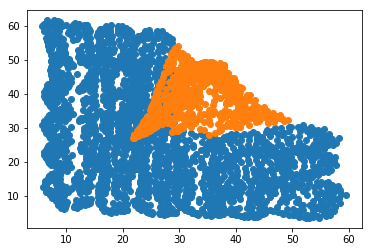

In [9]:
plt.scatter(train_preds[:,0],train_preds[:,1])
plt.scatter(test_preds[:,0],test_preds[:,1])
plt.show()

In [15]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,2))
y = tf.placeholder(tf.float32,shape=(None, 64, 64, 1))

inputs = tf.reshape(X,(-1,1,1,2))

act = tf.nn.relu

net = tf.layers.conv2d_transpose(inputs,16,4,2,padding="same",activation=act)
net = tf.layers.conv2d_transpose(net,16,4,2,padding="same",activation=act)
net = tf.layers.conv2d_transpose(net,16,4,2,padding="same",activation=act)
net = tf.layers.conv2d_transpose(net,16,4,2,padding="same",activation=act)
net = tf.layers.conv2d_transpose(net,16,4,2,padding="same",activation=act)
net = tf.layers.conv2d_transpose(net,1,4,2,padding="same",activation=None)
net = tf.reshape(net,(-1,64*64,1))
net = tf.nn.softmax(net,axis=(1))
net = tf.reshape(net,(-1,64,64,1))

loss = tf.reduce_mean(
    tf.reduce_sum( -y * tf.log(1e-8 + net) + (1-y) * -1 * tf.log(1e-8 + 1 - net),axis=(1,2)))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [16]:
num_epochs = 100
bs = 32
num_its_per_epoch = int(x_train.shape[0]/bs)

losses = []
val_losses = []
test_every = 50

x_train_p = np.random.permutation(x_train)
y_train_p = np.random.permutation(y_train)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for ep in tqdm(range(num_epochs)):
        for it in range(num_its_per_epoch):
            x_batch = y_train[it*bs: (it+1)*bs]
            y_batch = x_train[it*bs: (it+1)*bs]
            
            _, l = sess.run([train_op, loss], feed_dict={X:x_batch,y:y_batch})
            losses.append(l)
            
            if it % test_every == 0:
                vl= sess.run(loss, feed_dict={X:y_test,y:x_test})
                val_losses.append(vl)
                
    test_preds = sess.run(net, feed_dict={X:y_test,y:x_test})
    train_preds = sess.run(net,feed_dict={X:y_train,y:x_train})

A Jupyter Widget

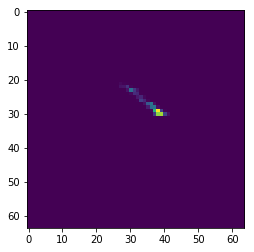

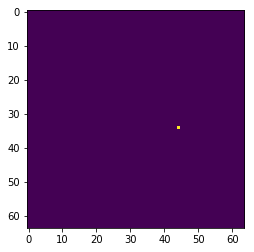

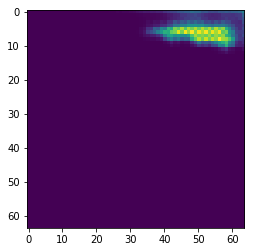

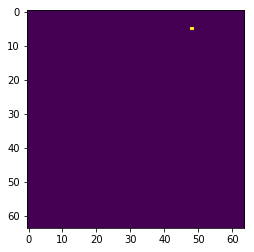

In [17]:
ind = 100
plt.imshow(test_preds[ind,:,:,0])
plt.show()
plt.imshow(x_test[ind,:,:,0])
plt.show()
plt.imshow(train_preds[ind,:,:,0])
plt.show()
plt.imshow(x_train[ind,:,:,0])
plt.show()

In [18]:
len(val_losses), num_its_per_epoch

(200, 71)

In [ ]:
plt.plot(losses)
plt.plot(np.arange(0,num_its_per_epoch*num_epochs,
                   num_its_per_epoch*num_epochs/len(val_losses)),val_losses)
plt.show()

## Experiment 2: The CoordConv Layer

In [20]:
from tensorflow.python.layers import base

class AddCoords(base.Layer):
    """Add coords to a tensor"""
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
        super(AddCoords, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r
        
    def call(self, input_tensor):
        """
        input_tensor: (batch, x_dim, y_dim, c)
        """
        batch_size_tensor = tf.shape(input_tensor)[0]
        xx_ones = tf.ones([batch_size_tensor, self.x_dim],
        dtype=tf.int32)
        xx_ones = tf.expand_dims(xx_ones, -1)
        xx_range = tf.tile(tf.expand_dims(tf.range(self.x_dim), 0),
        [batch_size_tensor, 1])
        xx_range = tf.expand_dims(xx_range, 1)
        xx_channel = tf.matmul(xx_ones, xx_range)
        xx_channel = tf.expand_dims(xx_channel, -1)

        yy_ones = tf.ones([batch_size_tensor, self.y_dim],
            dtype=tf.int32)
        yy_ones = tf.expand_dims(yy_ones, 1)
        yy_range = tf.tile(tf.expand_dims(tf.range(self.y_dim), 0),
            [batch_size_tensor, 1])
        yy_range = tf.expand_dims(yy_range, -1)
        yy_channel = tf.matmul(yy_range, yy_ones)
        yy_channel = tf.expand_dims(yy_channel, -1)
        xx_channel = tf.cast(xx_channel, 'float32') / (self.x_dim - 1)
        yy_channel = tf.cast(yy_channel, 'float32') / (self.y_dim - 1)
        xx_channel = xx_channel*2 - 1
        yy_channel = yy_channel*2 - 1
        ret = tf.concat([input_tensor,
                xx_channel,
                yy_channel], axis=-1)
        if self.with_r:
            rr = tf.sqrt( tf.square(xx_channel-0.5)
            + tf.square(yy_channel-0.5)
            )

            ret = tf.concat([ret, rr], axis=-1)
        return ret

class CoordConv(base.Layer):
    """CoordConv layer as in the paper."""
    def __init__(self, x_dim, y_dim, with_r, *args, **kwargs):
        super(CoordConv, self).__init__()
        self.addcoords = AddCoords(x_dim=x_dim,
            y_dim=y_dim,
            with_r=with_r)
        self.conv = tf.layers.Conv2D(*args, **kwargs)
        
    def call(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret

In [22]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,2))
y = tf.placeholder(tf.float32,shape=(None, 64*64))

inputs = tf.reshape(tf.tile(X/64,[1,64*64]),(-1,64,64,2))

act = tf.nn.relu
conv_fn = CoordConv
p = "same"
f = 1

net = conv_fn(64,64,False,32,f,1,padding=p,activation=act)(inputs)
net = tf.layers.conv2d(net,32,f,1,padding=p,activation = act)
net = tf.layers.conv2d(net,64,f,1,padding=p,activation = act)
net = tf.layers.conv2d(net,64,f,1,padding=p,activation = act)
net = tf.layers.conv2d(net,1,f,1,padding=p,activation = None)
net = tf.layers.flatten(net)
net = tf.nn.softmax(net,axis=1)
print(net.shape)
loss = tf.reduce_mean(
    tf.reduce_sum( -y * tf.log(1e-8 + net) + 0*(1-y) * -1 * tf.log(1e-8 + 1 - net),axis=1))

v = tf.argmax(net,axis=1)
correct = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(net,axis=1),tf.argmax(y,axis=1)),tf.int32))
acc = tf.cast(correct,tf.float32)/tf.cast(tf.shape(X)[0],tf.float32)

train_op = tf.train.AdamOptimizer(1e-2).minimize(loss)

(?, 4096)


In [23]:
g = tf.get_default_graph()

def get_num_params(graph):
    total = 0
    for var in graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        total += np.prod(var.shape.as_list())
    print(total)
    
get_num_params(g)

7553


In [ ]:
num_epochs = 10
bs = 32
num_its_per_epoch = int(x_train.shape[0]/bs)

losses = []
accs = []
val_accs = []
val_losses = []
test_every = 100

sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

for ep in tqdm(range(num_epochs)):
    shuffled = np.random.permutation(np.arange(x_train.shape[0]))
    x_train_p = x_train[shuffled]
    y_train_p = y_train[shuffled]
    for it in range(num_its_per_epoch):
        x_batch = y_train_p[it*bs: (it+1)*bs]
        y_batch = x_train_p[it*bs: (it+1)*bs].reshape((-1,64*64))

        _, l, n1, train_acc = sess.run([train_op, loss,inputs,acc], feed_dict={X:x_batch,y:y_batch})
        losses.append(l)
        accs.append(train_acc)

        if it % test_every == 0:
            vl,vacc= sess.run([loss,acc], feed_dict={X:y_test,y:x_test.reshape((-1,64*64))})
            val_losses.append(vl)
            val_accs.append(vacc)

test_preds = sess.run(net, feed_dict={X:y_test,y:x_test.reshape((-1,64*64))})
train_preds = sess.run(net,feed_dict={X:y_train,y:x_train.reshape((-1,64*64))})

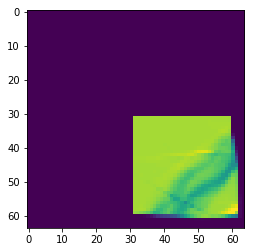

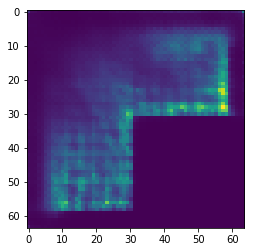

In [25]:
plt.imshow(np.sum(test_preds,axis=0).reshape((64,64)))
plt.show()
plt.imshow(np.sum(train_preds,axis=0).reshape((64,64)))
plt.show()

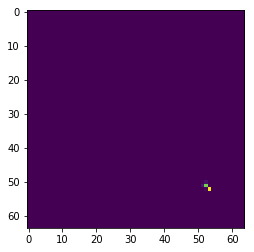

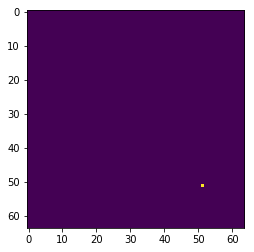

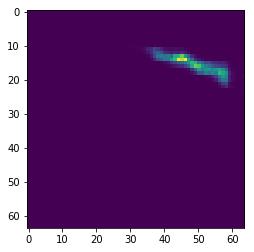

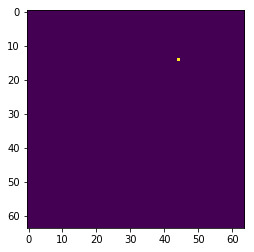

In [26]:
ind = 600
plt.imshow(test_preds[ind].reshape((64,64)))
plt.show()
plt.imshow(x_test[ind].reshape((64,64)))
plt.show()
plt.imshow(train_preds[ind].reshape((64,64)))
plt.show()
plt.imshow(x_train[ind].reshape((64,64)))
plt.show()

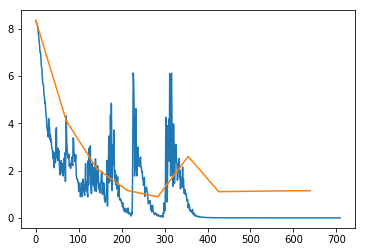

In [27]:
plt.plot(losses)
plt.plot(np.arange(0,num_its_per_epoch*num_epochs,
                   num_its_per_epoch*num_epochs/len(val_losses)),val_losses)
plt.show()

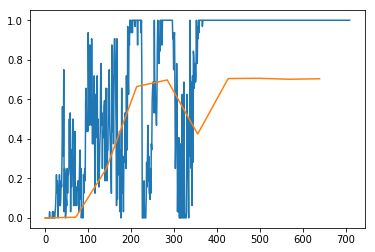

In [28]:
plt.plot(accs)
plt.plot(np.arange(0,num_its_per_epoch*num_epochs,
                   num_its_per_epoch*num_epochs/len(val_accs)),val_accs)
plt.show()